In [1]:
pip install torch torchvision segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import os
import random
import glob
import warnings

import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import albumentations as A

from segmentation_models_pytorch import losses, utils
from segmentation_models_pytorch import metrics
import os
from sklearn.model_selection import train_test_split

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Investigate classes

In [4]:
key = pd.read_csv('/content/drive/My Drive/ADL/class_dict.csv')
key

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [5]:
color_dict = {
    (0, 255, 255): 0,  # urban_land
    (255, 255, 0): 1,  # agriculture_land
    (255, 0, 255): 2,  # rangeland
    (0, 255, 0): 3,  # forest_land
    (0, 0, 255): 4,  # water
    (255, 255, 255): 5,  # barren_land
    (0, 0, 0): 6  # unknown
}

# Define a function which will convert the RGB mask to a binary mask
def rgb_to_binary_mask(mask, color_dict):

    # Initialize new mask with the same height and width as the original mask, and depth equal to the number of classes
    new_mask = np.zeros((*mask.shape[:2], len(color_dict)), dtype=int)

    # Fill the new mask where each slice corresponds to a class
    for idx, color in enumerate(color_dict.keys()):
        # Create a mask for the current class
        class_mask = np.all(mask == np.array(color, dtype=np.uint8), axis=-1)
        # Insert the class mask into the corresponding semantic slice
        new_mask[..., idx] = class_mask.astype(int)  # Convert boolean array to int

    return new_mask.astype('float')

# Create a PyTorch dataset

In [6]:
class SentinalDataset(Dataset):

    def __init__(self, sat_path, mask_path, preprocessing=None, transform=None):

        # Get paths of images and masks
        self.sat_path = sat_path
        self.mask_path = mask_path

        self.transform = transform
        self.preprocessing = preprocessing

    def __getitem__(self, id):

        # read images and masks
        image = np.array(Image.open(self.sat_path[id]))
        mask = np.array(Image.open(self.mask_path[id]))

        # one-hot-encode the mask
        mask = rgb_to_binary_mask(mask, color_dict).astype('float')

        # Transformations
        if self.transform:
          data = self.transform(image=image, mask=mask)
          image = data['image']
          mask = data['mask']

        # Pre-processing
        if self.preprocessing:
          data = self.preprocessing(image=image, mask=mask)
          image = data['image']
          mask = data['mask']
        return image, mask

    def __len__(self):
        return len(self.sat_path)

## Define Augmentations

In [7]:
transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(height=128, width=128, p=1.0),
])

## Define pre-processing (taken from DeepLabV3+)

In [8]:
def convert_to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# Preprocessing function
def preprocessing(func=None):
    _transform = []
    if func:
        _transform.append(A.Lambda(image=func))
    _transform.append(A.Lambda(image=convert_to_tensor, mask=convert_to_tensor))

    return A.Compose(_transform)



# Define model

In [9]:
# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    classes=len(color_dict),
    activation='sigmoid',
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


In [10]:
# Obtain preprocessing function used on the imagenet dataset
import_preprocessing = smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')
image_net_preprocessing = preprocessing(import_preprocessing)

In [11]:
# Train test split

# Set the directory containing the images
directory = '/content/drive/My Drive/ADL/train'

# Get a list of all files in the directory
files = os.listdir(directory)

# Extract unique image IDs from the filenames
image_ids = set(file.split('_')[0] for file in files if '_' in file)

# Split the image IDs into training and test sets
train_ids, valid_ids = train_test_split(list(image_ids), test_size=0.1, random_state=42)

# Function to generate file paths for the given IDs
def generate_paths(id_list):
    sat_paths = [os.path.join(directory, f"{image_id}_sat.jpg") for image_id in id_list]
    mask_paths = [os.path.join(directory, f"{image_id}_mask.png") for image_id in id_list]
    return sat_paths, mask_paths

# Get paths for training and testing data
train_sat_paths, train_mask_paths = generate_paths(train_ids)
valid_sat_paths, valid_mask_paths = generate_paths(valid_ids)

In [12]:
# Get train and val dataset instances
train_dataset = SentinalDataset(train_sat_paths, train_mask_paths, image_net_preprocessing, transform)
valid_dataset = SentinalDataset(valid_sat_paths, valid_mask_paths, image_net_preprocessing, transform)

print('Trainining set size:',len(train_dataset))
print('Validation set size:',len(valid_dataset))

Trainining set size: 722
Validation set size: 81


In [13]:
# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train model

In [14]:
# Ensure that the device is correctly set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
epochs = 80
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
metrics = [smp.utils.metrics.IoU(threshold=0.5),]
loss = smp.utils.losses.DiceLoss()

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

In [ ]:
TRAIN = True
if TRAIN:
  iou = 0.0
  train_logs_list = []
  valid_logs_list = []

  for epoch in range(epochs):
      print('Epoch: [{}/{}]'.format(epoch+1, epochs))

      # Perform training & validation
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)
      train_logs_list.append(train_logs)
      valid_logs_list.append(valid_logs)

      # Save model if its the current best
      if iou < valid_logs['iou_score']:
          iou = valid_logs['iou_score']
          torch.save(model, '/content/drive/My Drive/ADL/models/best_model.pth')
          print('Model saved!')

  import csv
  # Define the path to save your CSV file
  file_path = '/content/drive/My Drive/ADL/models/training_logs.csv'

  # Open a file in write mode
  with open(file_path, mode='w', newline='') as file:
      writer = csv.writer(file)
      # Write the headers
      writer.writerow(['Epoch', 'train_dice_loss', 'train_iou_score', 'valid_dice_loss', 'valid_iou_score'])

      # Write the data
      for i in range(epochs):
          writer.writerow([
              i+1,  # Epoch number
              train_logs_list[i]['dice_loss'],
              train_logs_list[i]['iou_score'],
              valid_logs_list[i]['dice_loss'],
              valid_logs_list[i]['iou_score'],

          ])

  print("Logs have been saved to:", file_path)


Epoch: [1/80]
train:   0%|          | 0/241 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


valid: 100%|██████████| 81/81 [00:02<00:00, 33.79it/s, dice_loss - 0.7915, iou_score - 0.144]
Model saved!
Epoch: [2/80]
valid: 100%|██████████| 81/81 [00:03<00:00, 26.14it/s, dice_loss - 0.7301, iou_score - 0.3253]
Model saved!
Epoch: [3/80]
valid: 100%|██████████| 81/81 [00:02<00:00, 31.35it/s, dice_loss - 0.714, iou_score - 0.365]
Model saved!
Epoch: [4/80]
valid: 100%|██████████| 81/81 [00:02<00:00, 35.62it/s, dice_loss - 0.6649, iou_score - 0.4832]
Model saved!
Epoch: [5/80]
valid: 100%|██████████| 81/81 [00:03<00:00, 26.22it/s, dice_loss - 0.6293, iou_score - 0.4929]
Model saved!
Epoch: [6/80]
valid: 100%|██████████| 81/81 [00:02<00:00, 33.58it/s, dice_loss - 0.5821, iou_score - 0.5499]
Model saved!
Epoch: [7/80]
valid: 100%|██████████| 81/81 [00:02<00:00, 35.74it/s, dice_loss - 0.5379, iou_score - 0.5853]
Model saved!
Epoch: [8/80]
valid: 100%|██████████| 81/81 [00:03<00:00, 23.90it/s, dice_loss - 0.5454, iou_score - 0.5394]
Epoch: [9/80]
valid: 100%|██████████| 81/81 [00:02<00:

## Plot metrics

In [17]:
logs =  pd.read_csv('/content/drive/My Drive/ADL/models/training_logs.csv')


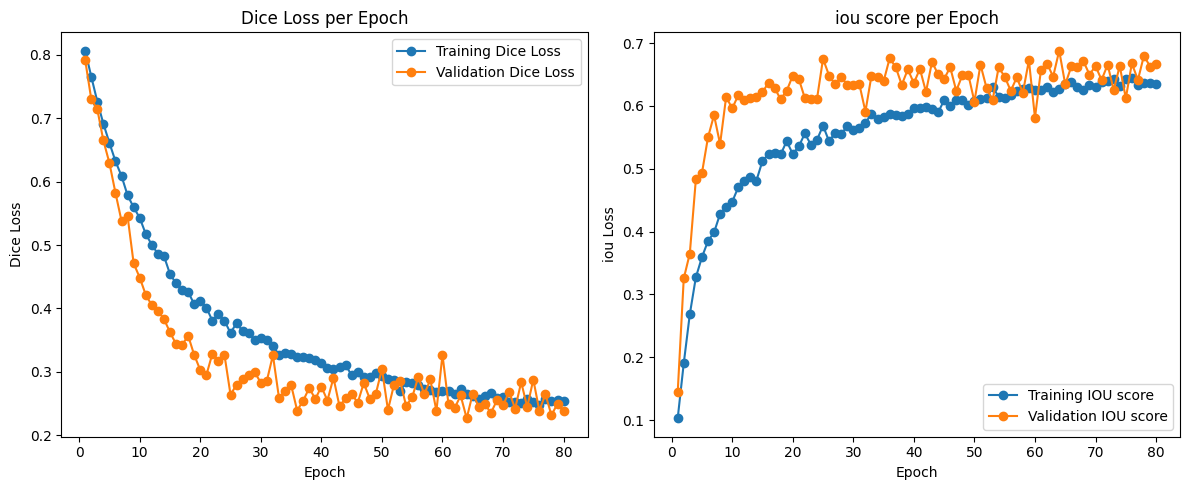

In [18]:
# Extracting Dice Loss and IoU scores
train_dice_loss = logs['train_dice_loss']
train_iou_score = logs['train_iou_score']
valid_dice_loss = logs['valid_dice_loss']
valid_iou_score = logs['valid_iou_score']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
epochs = range(1, len(train_dice_loss) + 1)

# Dice Loss plot
axes[0].plot(epochs, train_dice_loss, label='Training Dice Loss', marker='o')
axes[0].plot(epochs, valid_dice_loss, label='Validation Dice Loss', marker='o')
axes[0].set_title('Dice Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Dice Loss')
axes[0].legend()

axes[1].plot(epochs, train_iou_score, label='Training IOU score', marker='o')
axes[1].plot(epochs, valid_iou_score, label='Validation IOU score', marker='o')
axes[1].set_title('iou score per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('iou Loss')
axes[1].legend()


plt.tight_layout()
plt.show()

## Inspect masks of validation set

In [19]:
# Convert binary masks to rgb values
def binary_mask_to_rgb(mask, color_dict):

    # Reverse the color dictionary to map from class labels to colors
    label_to_color = {v: k for k, v in color_dict.items()}

    # Initialize an empty RGB image with the shape (height, width, 3)
    rgb_image = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Map each class label in the mask to its corresponding RGB color
    for label, color in label_to_color.items():
        rgb_image[mask == label] = color

    return rgb_image


In [20]:
model = torch.load('/content/drive/My Drive/ADL/models/best_model.pth')

In [21]:
model = model.to(device)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [22]:
# Convert binary masks to rgb values
def mask_to_rgb(mask):

  color_dict_ = {
      0: (0, 255, 255),    # urban_land
      1: (255, 255, 0),    # agriculture_land
      2: (255, 0, 255),    # rangeland
      3: (0, 255, 0),      # forest_land
      4: (0, 0, 255),      # water
      5: (255, 255, 255),  # barren_land
      6: (0, 0, 0)         # unknown
  }

  class_indices = np.argmax(mask, axis=-1)
  rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

  for class_index, color in color_dict_.items():
    rgb_image[class_indices == class_index] = color

  return rgb_image


In [23]:
def plot_images(original_image, predicted_mask, true_mask=None):

    if true_mask is not None:
        # Plot original image, true mask, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        images = [original_image, true_mask, predicted_mask]
        titles = ['Original Image', 'True Mask', 'Predicted Mask']
    else:
        # Plot only the original image and the predicted mask
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        images = [original_image, predicted_mask]
        titles = ['Original Image', 'Predicted Mask']

    # Plot each image
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')  # Turn off axis labels and ticks

    # Display the plots
    plt.tight_layout()
    plt.show()


In [24]:
# Create a dataset with no augmentations
valid_dataset = SentinalDataset(
    valid_sat_paths,
    valid_mask_paths,
    preprocessing = image_net_preprocessing,
)


# valid dataset for graphs with no preprocessing
valid_dataset_graph = SentinalDataset(
    valid_sat_paths,
    valid_mask_paths
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


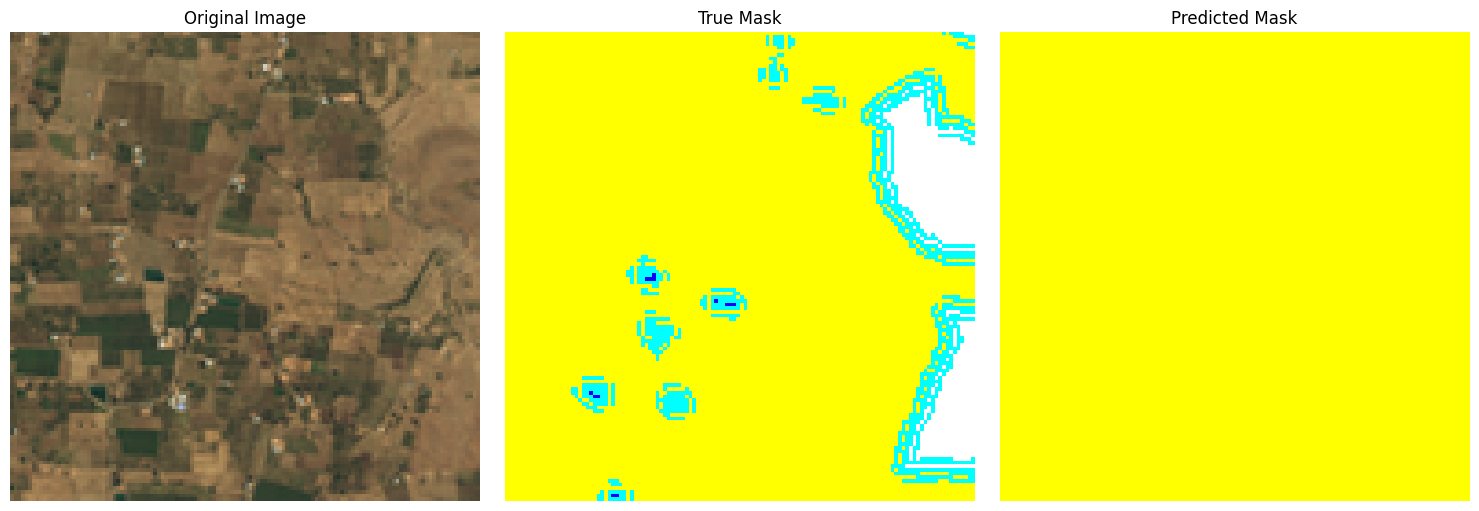

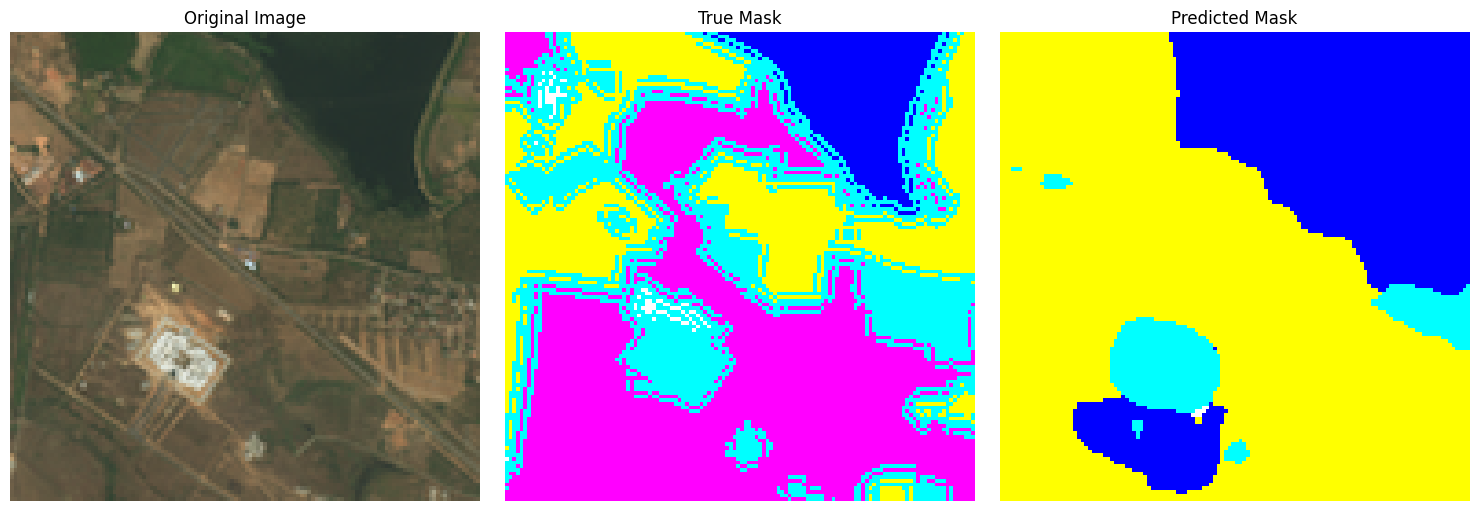

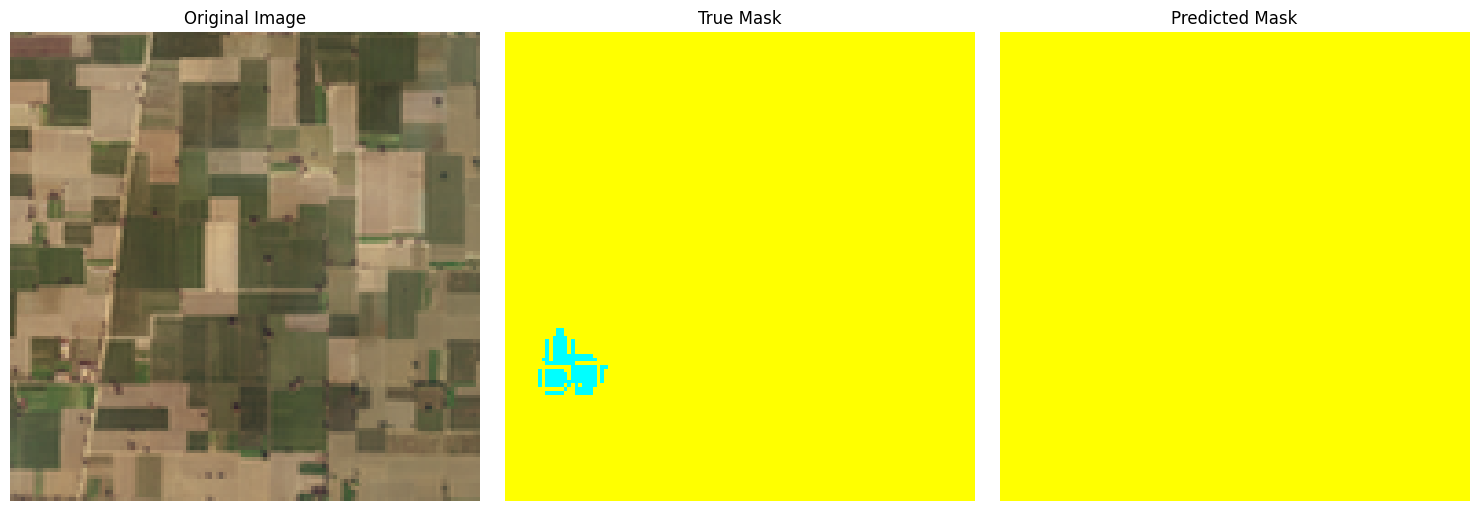

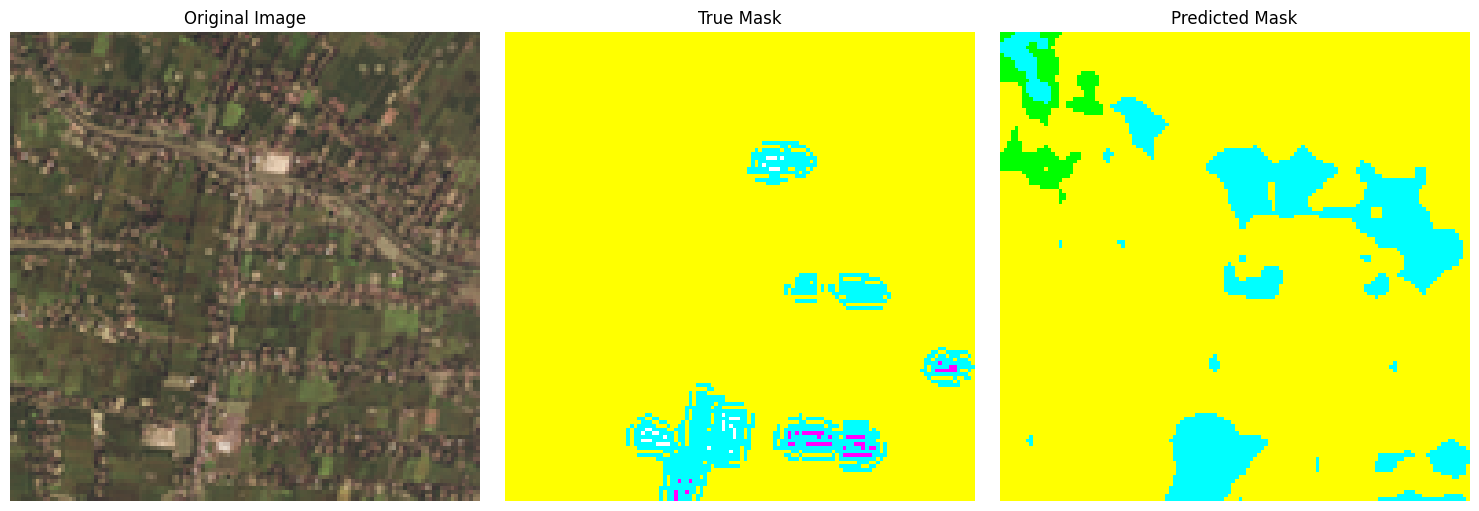

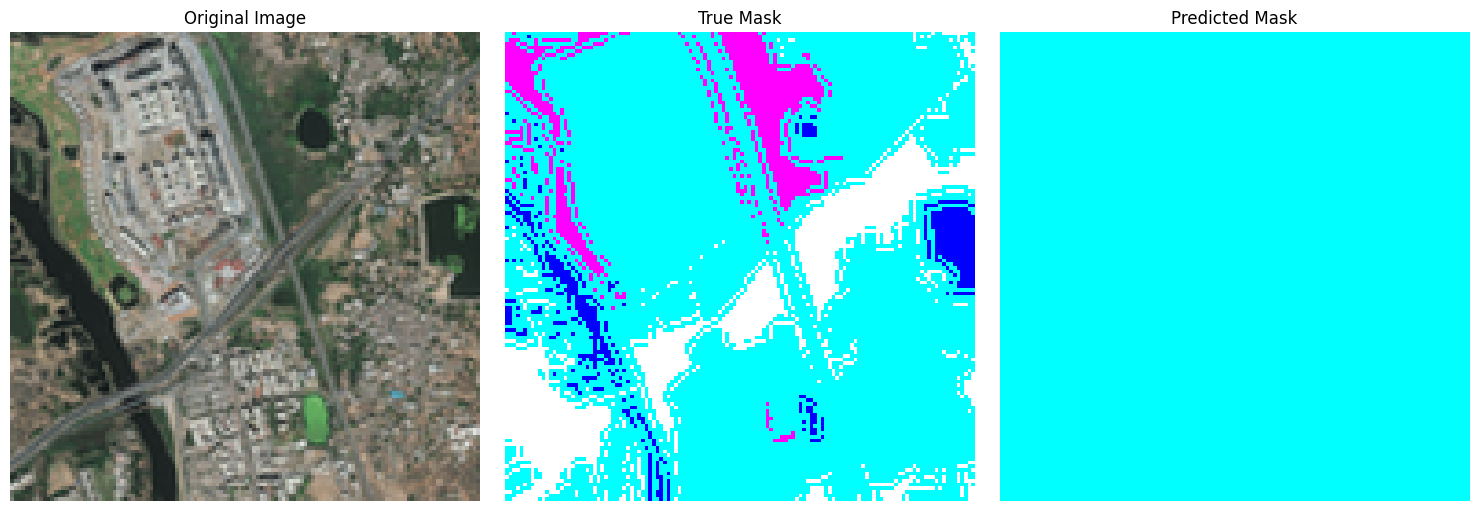

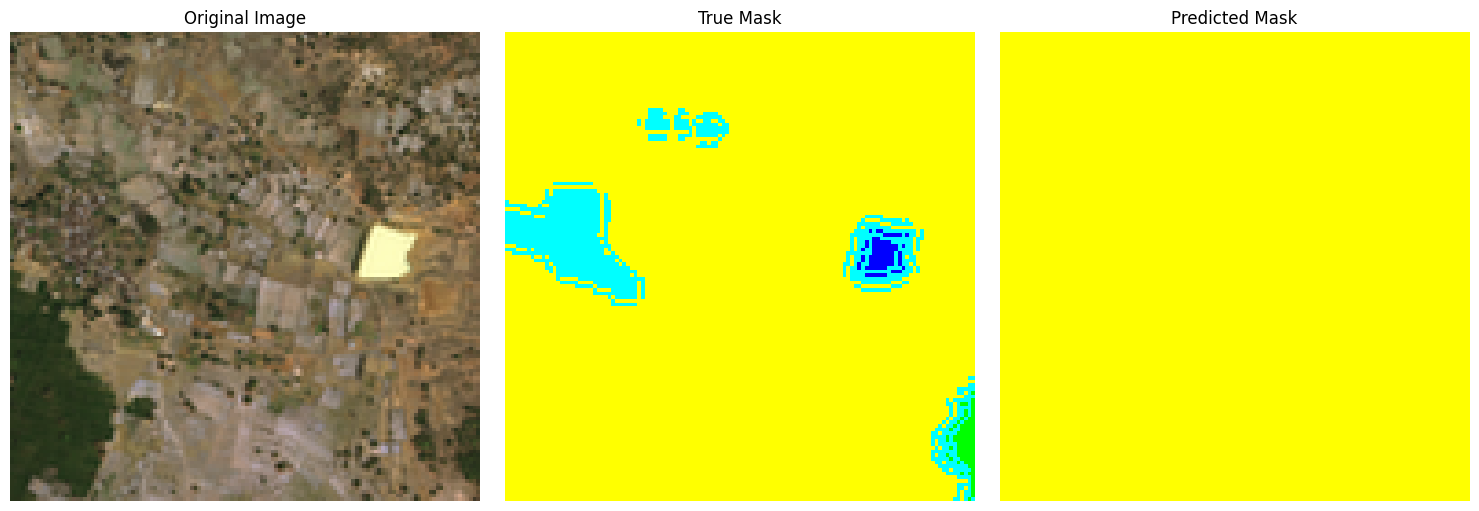

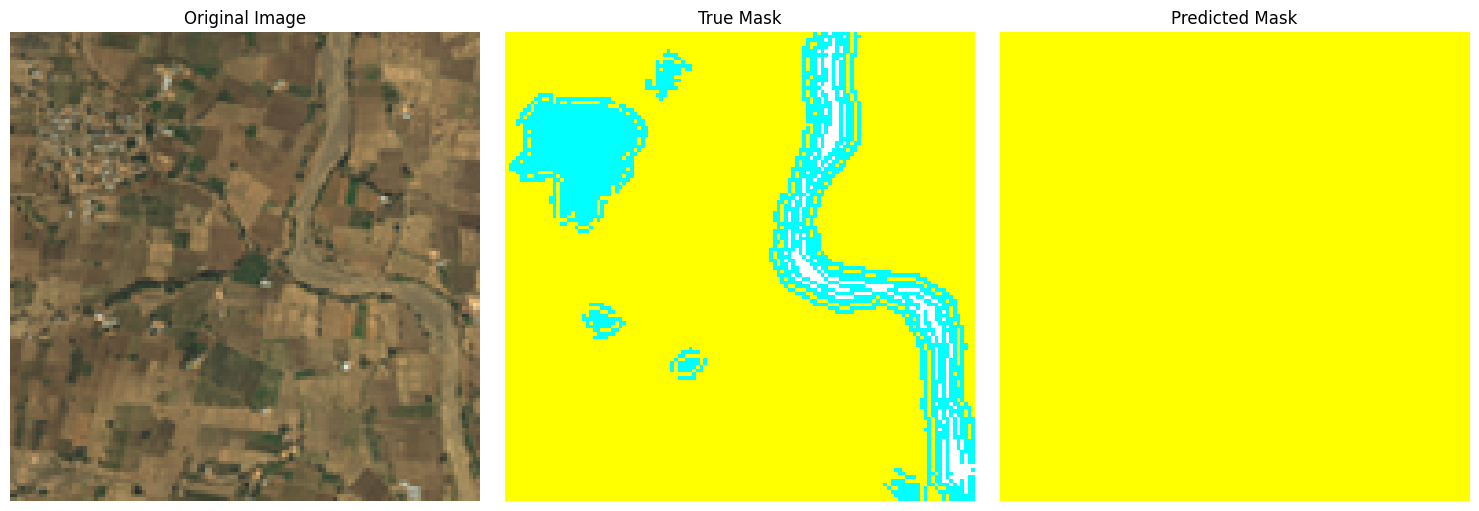

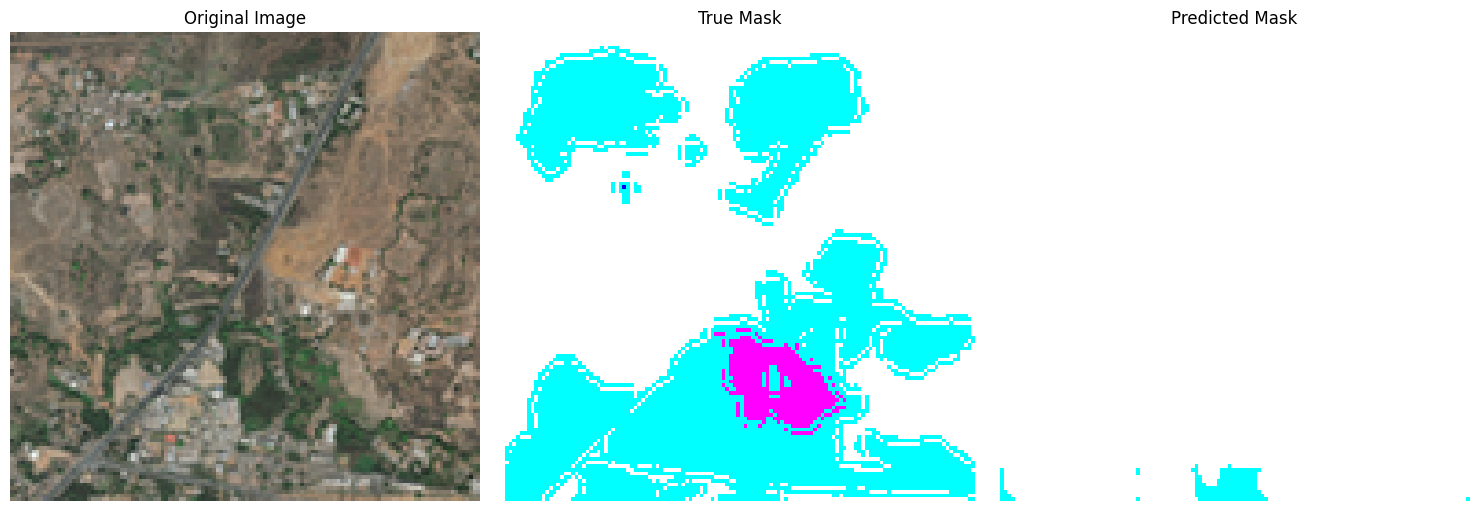

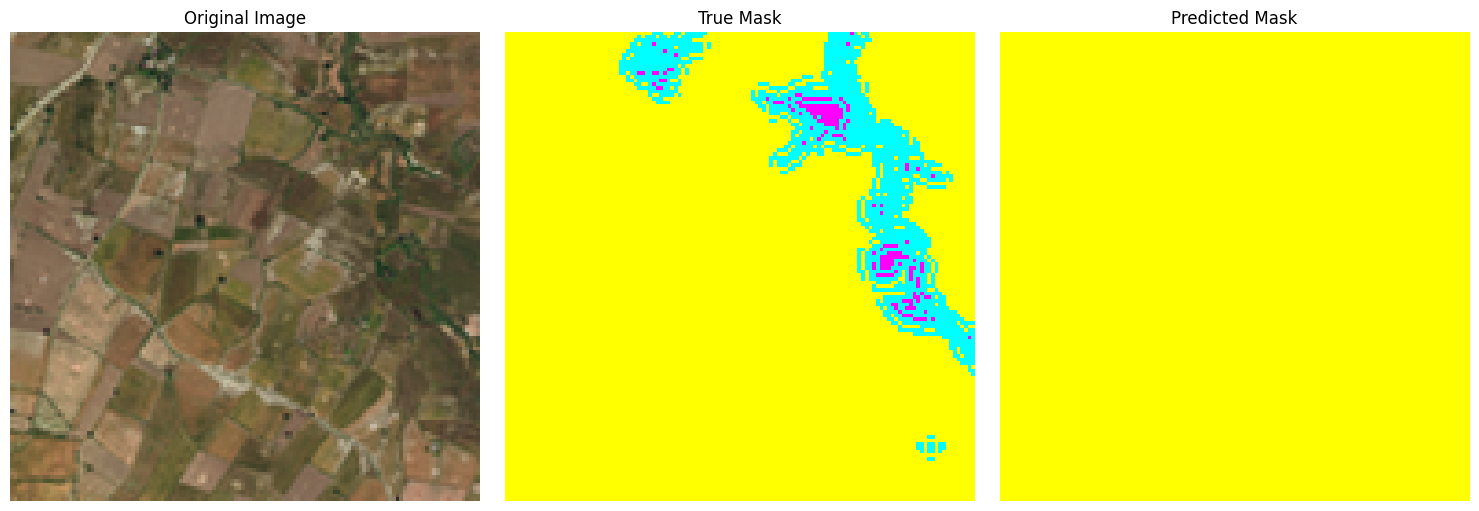

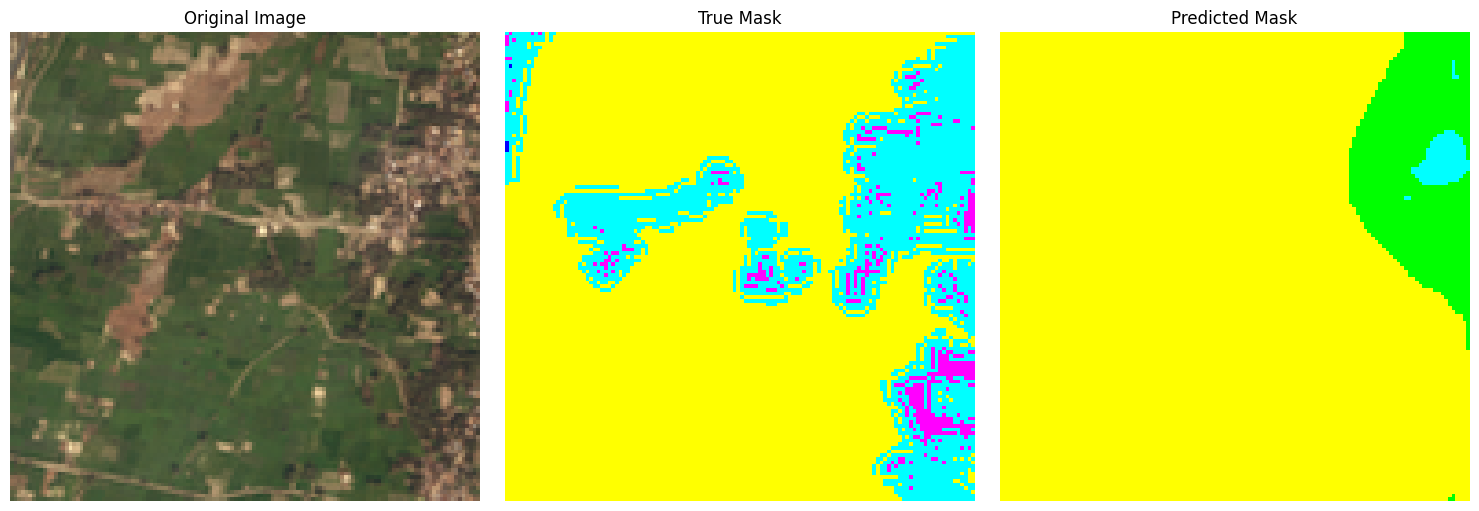

In [25]:
# Number of random samples
num_samples = 10  # Set x to the number of samples you want

# Generate random indices
random_indices = np.random.choice(len(valid_dataset_graph), num_samples, replace=False)

for idx in random_indices:
    # Get true mask and images from the visual valid dataset
    image, true_mask = valid_dataset_graph[idx]

    # Get predictions
    image_, mask_ = valid_dataset[idx]
    x_tensor = torch.from_numpy(image_).to(device).unsqueeze(0)

    # Predict the mask
    predicted_mask = model(x_tensor)
    predicted_mask = predicted_mask.detach().squeeze().cpu().numpy()

    # Change the shape of the predicted mask
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    # Convert masks to RGB
    predicted_mask = mask_to_rgb(predicted_mask)
    true_mask = mask_to_rgb(true_mask)

    # Plot images
    plot_images(image, predicted_mask, true_mask)


# Produce masks for test images

In [26]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.4 MB/s eta 0:00:00


In [33]:
# Make class which doesnt require labels
import rasterio

class SentinelDataset_test(Dataset):
    def __init__(self, sat_path, preprocessing=None):
        self.sat_path = sat_path
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        # Open the image file with rasterio

        with rasterio.open(self.sat_path[idx]) as src:

            # Read the first three channels
            red = src.read(1)  # Band 1 corresponds to B4
            green = src.read(2)  # Band 2 corresponds to B3
            blue = src.read(3)  # Band 3 corresponds to B2


            # Stack the R, G, B arrays into a single three-dimensional array
            image = np.stack((red, green, blue), axis=-1)

            # Normalize the bands to (0, 1) scale
            image = image.astype('float')
            image /= image.max()

        # Pre-processing
        if self.preprocessing:
            data = self.preprocessing(image=image)
            image = data['image']

        return image, self.sat_path[idx]

    def __len__(self):
        return len(self.sat_path)


In [38]:
# Get all file names
def list_all_files(directory):
    file_paths = []  # List to store all file paths
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

# Specify the directory
directory = '/content/drive/My Drive/ADL/test/cat'

# Get all file paths
catalonia_paths = list_all_files('/content/drive/My Drive/ADL/test_downscaled/cat')
ar_paths = list_all_files('/content/drive/My Drive/ADL/test_downscaled/ar')

In [29]:
# Preprocessing function
def preprocessing_test(func=None):
    _transform = []
    if func:
        _transform.append(A.Lambda(image=func))
    _transform.append(A.Lambda(image=convert_to_tensor))


    return A.Compose(_transform)

# Obtain preprocessing function used on the imagenet dataset
import_preprocessing_test = smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')
image_net_preprocessing_test = preprocessing_test(import_preprocessing_test)

In [30]:
# Make datasets
test_dataset_catalonia = SentinelDataset_test(catalonia_paths, image_net_preprocessing_test)
test_dataset_ar = SentinelDataset_test(ar_paths, image_net_preprocessing_test)


test_dataset_catalonia_graph = SentinelDataset_test(catalonia_paths)
test_dataset_ar_graph = SentinelDataset_test(ar_paths)

In [39]:
output_dir = '/content/drive/My Drive/ADL/test_masks/cat'

for idx in range(len(test_dataset_catalonia_graph)):
    # Get true mask and images from the visual test dataset
    image, file_path = test_dataset_catalonia_graph[idx]

    # Get predictions
    image_, file = test_dataset_catalonia[idx]
    x_tensor = torch.from_numpy(image_).to(device).unsqueeze(0)

    # Predict the mask
    predicted_mask = model(x_tensor)
    predicted_mask = predicted_mask.detach().squeeze().cpu().numpy()

    # Change the shape of the predicted mask
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    # Convert masks to RGB
    predicted_mask_rgb = mask_to_rgb(predicted_mask)

    # Save predicted mask as PNG
    filename = os.path.basename(file_path)
    filename = filename.replace('.tif', '')

    output_path = os.path.join(output_dir, f'{filename}.png')
    plt.imsave(output_path, predicted_mask_rgb)

    # plot_images(image, predicted_mask)



In [40]:
output_dir = '/content/drive/My Drive/ADL/test_masks/ar'

for idx in range(len(test_dataset_ar_graph)):
    # Get true mask and images from the visual test dataset
    image, file_path = test_dataset_ar_graph[idx]

    # Get predictions
    image_, file = test_dataset_ar[idx]
    x_tensor = torch.from_numpy(image_).to(device).unsqueeze(0)

    # Predict the mask
    predicted_mask = model(x_tensor)
    predicted_mask = predicted_mask.detach().squeeze().cpu().numpy()

    # Change the shape of the predicted mask
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    # Convert masks to RGB
    predicted_mask_rgb = mask_to_rgb(predicted_mask)

    # Save predicted mask as PNG
    filename = os.path.basename(file_path)
    filename = filename.replace('.tif', '')

    output_path = os.path.join(output_dir, f'{filename}.png')
    plt.imsave(output_path, predicted_mask_rgb)